In [10]:
import pandas as pd
import re
# from tqdm.auto import tqdm
from tqdm.notebook import tqdm
import yfinance as yf
# import swifter
import numpy as np
from collections import OrderedDict

#載入PCA套件
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
import matplotlib.colors as colors
plt.rcParams['font.sans-serif'] = ['SimHei'] # 修改中文字體
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

import quantstats as qs

from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

import math



In [11]:
'''加入產業'''
raw_sector = pd.read_excel('Data/TEJ_產業別.xlsx')

filter = (raw_sector['上市別'] == 'OTC') | (raw_sector['上市別'] == 'TSE')
raw_sector = raw_sector[filter]
raw_sector['codes'] = raw_sector.apply(lambda x: x['代號'] + '.TW' if x['上市別'] == 'TSE' else x['代號'] + '.TWO', axis = 1)
raw_sector = raw_sector[['名稱','codes','TSE新產業_名稱']]

sectors = list(set(raw_sector['TSE新產業_名稱']))

raw_sector = raw_sector.reset_index(drop = True)

In [12]:
# command = ''
# for i in range(0,len(raw_sector['codes'])):
#     command += raw_sector['codes'][i]+' '
    

# raw_data = yf.download(command)['Close']
# raw_data.to_csv('Data2/raw_data.csv')

raw_data = pd.read_csv('Data2/raw_data.csv', index_col = 0)
time_index = pd.to_datetime(raw_data.index)
stock_column = raw_data.columns

# 市值 ＆ PB

In [13]:
value = pd.read_excel('Data2/PB_Value.xlsx')
filter = (value['市場別'] == 'OTC') | (value['市場別'] == 'TSE')
value  = value[filter]
value['codes'] = value.apply(lambda x: x['代號'] + '.TW' if x['市場別'] == 'TSE' else x['代號'] + '.TWO', axis = 1)
value['財報發布日'] = pd.to_datetime(value['財報發布日'])

In [14]:
tmp_index = list(time_index)
for tmp in tqdm(value['財報發布日']):
    if tmp not in tmp_index:
        tmp_index.append(tmp)
tmp_index.sort()

  0%|          | 0/112260 [00:00<?, ?it/s]

In [15]:
raw_df_value = pd.DataFrame(index = tmp_index)
for i in tqdm(range(0,len(stock_column))):
    tmp = value[value['codes'] == stock_column[i]][['財報發布日','季底普通股市值','每股淨值(C)','季底每股稅前淨利']]
    tmp.index = tmp['財報發布日'].values
    tmp = tmp.sort_index()
    tmp = tmp.drop_duplicates(subset = '財報發布日',keep = 'last')

    tmp_ = pd.DataFrame()
    tmp_[stock_column[i]] = tmp['季底普通股市值']
    raw_df_value = raw_df_value.join(tmp_[stock_column[i]]).ffill()
    
raw_df_value['time'] = raw_df_value.index
raw_df_value['type'] = raw_df_value.apply(lambda x: 1 if x.time in time_index else 0, axis = 1)
raw_df_value = raw_df_value[raw_df_value['type'] == 1]

del raw_df_value['time']
del raw_df_value['type']
raw_df_value = raw_df_value['2008':]
# raw_df_value.index = raw_df_value.index.astype(str)

  0%|          | 0/1817 [00:00<?, ?it/s]

In [16]:
raw_df_PB = pd.DataFrame(index = tmp_index)
for i in tqdm(range(0,len(stock_column))):
    tmp = value[value['codes'] == stock_column[i]][['財報發布日','季底普通股市值','每股淨值(C)','季底每股稅前淨利']]
    tmp.index = tmp['財報發布日'].values
    tmp = tmp.sort_index()
    tmp = tmp.drop_duplicates(subset = '財報發布日',keep = 'last')

    tmp_ = pd.DataFrame()
    tmp_[stock_column[i]] = tmp['每股淨值(C)']
    raw_df_PB = raw_df_PB.join(tmp_[stock_column[i]]).ffill()
    
raw_df_PB['time'] = raw_df_PB.index
raw_df_PB['type'] = raw_df_PB.apply(lambda x: 1 if x.time in time_index else 0, axis = 1)
raw_df_PB = raw_df_PB[raw_df_PB['type'] == 1]

del raw_df_PB['time']
del raw_df_PB['type']
raw_df_PB = raw_df_PB['2008':]

  0%|          | 0/1817 [00:00<?, ?it/s]

In [17]:
# df = raw_data.pct_change()['2008':].mean(axis = 1)
# df.index = pd.to_datetime(df.index)
# qs.reports.full(df['2012':], benchmark = market_return['2012':])

# PCA

In [18]:
def process(VALUE_RANK, VALUE_RANK_N, T, N, DAYS):
    raw_return = raw_data.pct_change()['2008':]
    weighted_df = np.multiply(raw_return,raw_df_value)
    weighted_df = weighted_df['2008':]

    for sector in sectors:
        raw_sector[raw_sector['TSE新產業_名稱'] == sector]

    # sectors_df = pd.DataFrame()
    # for i in range(0,len(sectors)):
    #     tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
    #     tmp_ = weighted_df[tmp].mean(axis = 1)
    #     sectors_df[sectors[i]] = tmp_

    '''一開始再篩的時候，就篩市值'''
    sectors_df = pd.DataFrame()
    for i in range(0,len(sectors)):
        tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
        tmp_ = np.multiply(weighted_df[tmp], raw_df_value[tmp].rank(axis = 1) < round(len(tmp)*VALUE_RANK)).mean(axis = 1)
        sectors_df[sectors[i]] = tmp_

    half_life = list((1/2)**(np.arange(T,0,-1)/T))
    rolling_sectors_df = pd.DataFrame(sectors_df.rolling(T))

    #輸入有多少成分我們想要留住分解
    pca = PCA(n_components = N)

    dates = []
    centralities = {}
    for i in tqdm(range(T, len(rolling_sectors_df))):
    # for i in range(T, T+5):
        df = rolling_sectors_df.iloc[i,0].mul(half_life, axis = 0)
        date = df.index[-1]
        
        #將資料分成兩個主成份
        X = df.cov()
        pca.fit(X)
        x_pca = pca.transform(X)

        # 主成份的解釋力
        absorption_ratios = pca.explained_variance_ratio_

        # 各產業集中度
        # centralities = {'產業集中度':[]}
        centralities[date] = []
        for i in range(len(x_pca)):
            eigien_ratio = 0
            for j in range(0,N):
                eigien_ratio += (np.abs(x_pca[i,j])/ np.abs(x_pca.T[j]).sum())*absorption_ratios[j]
            centrality = eigien_ratio/absorption_ratios.sum()
            centralities[date].append(centrality)
            
    centralities = pd.DataFrame(centralities)
    centralities.index = df.keys()
    centralities = centralities.T

    standard_centralities = (centralities - centralities.rolling(DAYS).mean())/centralities.rolling(DAYS).std()

    cmap = colors.LinearSegmentedColormap.from_list("brw", ["white", "blue", "red"], N = len(sectors))

    # rank_centralities = centralities.rank(axis = 1, ascending = False).T
    rank_centralities = standard_centralities['2012':].rank(axis = 1, ascending = False)
    # plt.figure(figsize = (20,9))
    # # sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
    # sns.set_style("whitegrid",{"font.sans-serif":['SimHei']})
    # sns.heatmap(rank_centralities.T, annot = False, cmap='coolwarm_r')
    # plt.title('Rank Heatmap')
    # plt.savefig('Rank Heatmap.png')
    # plt.show()

    PB_ratio = np.multiply(raw_data['2008':],1/raw_df_PB)

    PB_sector = pd.DataFrame()
    for i in range(0,len(sectors)):
        tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
        tmp_ = PB_ratio[tmp].sum(axis = 1)
        PB_sector[sectors[i]] = tmp_

    tmp = PB_sector/PB_sector.rolling(DAYS).mean()
    PB_star = pd.DataFrame()
    for sector in list(PB_sector.columns):
        columns = list(PB_sector.columns)
        columns.remove(sector)
        PB_star[sector] = tmp[sector]/(tmp[columns]).mean(axis = 1)

    '''PB ratio'''

    rank_PB_star = PB_star['2012':].rank(axis = 1, ascending = False)
    # plt.figure(figsize = (20,9))
    # # sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
    # sns.set_style("whitegrid",{"font.sans-serif":['SimHei']})
    # sns.heatmap(rank_PB_star.T, annot = False, cmap='coolwarm_r')
    # plt.title('Rank Heatmap')
    # plt.savefig('Rank Heatmap.png')
    # plt.show()


    '''交易'''
    sectors_df = pd.DataFrame()
    VALUE_RANK = 1 # 若交易該產業中所有股票
    for i in range(0,len(sectors)):
        tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
        # print('交易')
        if VALUE_RANK == 0 :
            tmp_ = np.multiply(raw_return[tmp], raw_df_value[tmp].rank(axis = 1)< VALUE_RANK_N).mean(axis = 1)
            # print(math.ceil(len(tmp)*VALUE_RANK_N))
            # tmp_ = raw_return[tmp].mean(axis = 1)
        else:
            tmp_ = np.multiply(raw_return[tmp], raw_df_value[tmp].rank(axis = 1) < math.ceil(len(tmp)*VALUE_RANK)).mean(axis = 1)
        sectors_df[sectors[i]] = tmp_
        # print(round(len(tmp)*VALUE_RANK_N))
    print('finish process')
    return raw_return, rank_PB_star, rank_centralities, sectors_df

# 記錄結果

In [19]:
def get_results(result_type, rank_PB_star, rank_centralities, DB_new, RANK_RESULT):
    
    if result_type == 1:
        rank_PB_star_bool = rank_PB_star > RANK_RESULT
        rank_centralities_bool = rank_centralities > RANK_RESULT

    elif result_type == 2:
        rank_PB_star_bool = rank_PB_star <= RANK_RESULT
        rank_centralities_bool = rank_centralities > RANK_RESULT

    elif result_type == 4:
        rank_PB_star_bool = rank_PB_star <= RANK_RESULT
        rank_centralities_bool = rank_centralities <= RANK_RESULT

    elif result_type == 3:
        rank_PB_star_bool = rank_PB_star > RANK_RESULT
        rank_centralities_bool = rank_centralities <= RANK_RESULT

    bool_df = (rank_PB_star_bool*rank_centralities_bool).shift(1)
    

    DB_new = DB_new*bool_df
    # yearly_return = (DB_new*bool_df).mean()*252
    yearly_return = ((DB_new*bool_df).sum(axis = 1)/bool_df.sum(axis = 1))*252

    return bool_df, DB_new, yearly_return

In [20]:
VALUE_RANK_s = [0.1]# 取percentile
VALUE_RANK_N = 5 # 取前幾名
T = 125 # 半衰期
N = 2 # PCA 成分
DAYSs = [252*3] # PCA & PB
RANK_RESULTs = [5]


for VALUE_RANK in tqdm(VALUE_RANK_s):
# for VALUE_RANK_N in tqdm(VALUE_RANK_Ns):
    for DAYS in DAYSs:
        for RANK_RESULT in RANK_RESULTs:
            raw_return, rank_PB_star, rank_centralities, sectors_df = process(VALUE_RANK, VALUE_RANK_N, T , N, DAYS)

            df_results = pd.DataFrame()

            bool_no_b_1, no_b_1, df_results['no bubble_1'] = get_results(result_type = 1, rank_PB_star = rank_PB_star, rank_centralities = rank_centralities, DB_new = sectors_df['2012':], RANK_RESULT = RANK_RESULT)
            bool_no_b_2, no_b_2, df_results['no bubble_2'] = get_results(result_type = 2, rank_PB_star = rank_PB_star, rank_centralities = rank_centralities, DB_new = sectors_df['2012':], RANK_RESULT = RANK_RESULT)
            bool_b_r, b_r, df_results['bubble runup'] = get_results(result_type = 3, rank_PB_star = rank_PB_star, rank_centralities = rank_centralities, DB_new = sectors_df['2012':], RANK_RESULT = RANK_RESULT)
            bool_b_s, b_s, df_results['bubble selloff'] = get_results(result_type = 4, rank_PB_star = rank_PB_star, rank_centralities = rank_centralities, DB_new = sectors_df['2012':], RANK_RESULT = RANK_RESULT)

            pd.DataFrame(df_results.fillna(0).mean()).to_csv('Data2/Result/'f'daily_results_mean_{VALUE_RANK}_{VALUE_RANK_N}_{T}_{DAYS}_{RANK_RESULT}.csv')

            df = b_r.sum(axis = 1)/bool_b_r.sum(axis = 1)
            df.index = pd.to_datetime(df.index)
            # qs.reports.full(df)

            tmp = qs.reports.metrics(df, display = False)
            tmp.to_excel('Data2/Result/'f'daily_performance_{VALUE_RANK}_{VALUE_RANK_N}_{T}_{DAYS}_{RANK_RESULT}.xlsx', index = False)

            

  0%|          | 0/1 [00:00<?, ?it/s]

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Seri

  0%|          | 0/3868 [00:00<?, ?it/s]

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:71: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a 

finish process


# 統計檢定

In [21]:
df_results.mean(axis = 0)

no bubble_1       0.091799
no bubble_2       0.109076
bubble runup      0.112020
bubble selloff    0.082368
dtype: float64

# 資產配置河流圖

In [22]:
tmp_bool_b_r = bool_b_r.applymap(lambda x: 1 if x == True else 0)
tmp_bool_b_r['total'] = tmp_bool_b_r.sum(axis = 1)
for col in tmp_bool_b_r.columns:
    tmp_bool_b_r[col] = tmp_bool_b_r[col]/tmp_bool_b_r['total']
del tmp_bool_b_r['total']

In [23]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# fig = make_subplots(
#     rows = 1, cols = 1,
#     shared_xaxes = False ,
#     vertical_spacing=0.1,
#     specs=[[{"type": "scatter"}],
#         # [{"type": "scatter"}],
#         #  [{"type": "scatter"}],
#         # [{"type": "table"}]
#         ]
# )

# for idx, col in enumerate(tmp_bool_b_r):
#     fig.add_trace(go.Scatter(
#         x = tmp_bool_b_r.index, y = tmp_bool_b_r[col].values,
#         mode='lines',
#         line=dict(width=0.5),
#         stackgroup='one',
#         name=col,
#         hovertemplate='%{y:.1%}',
#         showlegend=False,
#         legendgroup=col
        
#     ),secondary_y=False, row = 1, col = 1)
    
# fig.update_layout(
#     title_text="Soto's Sector Rotation", hovermode = "x unified", autosize=False,
#     width=1600,
#     height=900,
# )
# fig.show()

# 實際損益

In [24]:
# profit_bool_b_r = bool_b_r.applymap(lambda x : 1 if x == True else 0)
# tmp = []
# tmp__ = []
# for i in range(0,len(profit_bool_b_r)):
#     tmp.append(profit_bool_b_r.iloc[i][profit_bool_b_r.iloc[i] != 0].index.values)
#     if len(tmp[-1]) > 0 :
#         tmp_ = []
#         for j in range(0,len(tmp[-1])):
#             tmp_.append(raw_sector['codes'][raw_sector['TSE新產業_名稱'] == tmp[-1][j]].values)
#     else:
#         tmp_ = ['']
#     tmp__.append(tmp_)
# profit_bool_b_r['投資產業'] = tmp
# profit_bool_b_r['投資標的'] = tmp__

In [25]:
# '''交易'''
# sectors_df = pd.DataFrame()
# for i in range(0,len(sectors)):
#     tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
#     if VALUE_RANK == 0 :
#         tmp_ = np.multiply(raw_return[tmp], raw_df_value[tmp].rank(axis = 1) < round(len(tmp)*VALUE_RANK_N)).mean(axis = 1)
#     else:
#         tmp_ = np.multiply(raw_return[tmp], raw_df_value[tmp].rank(axis = 1) < math.ceil(len(tmp)*VALUE_RANK)).mean(axis = 1)
#     sectors_df[sectors[i]] = tmp_

# 估算損益

In [26]:
# 大盤
# market = yf.download('^TWII')['Close']
market = pd.read_csv('market.csv', index_col = 'Date')['Close']
market.index = pd.to_datetime(market.index)
market_return = market[market.index > pd.to_datetime('2011-01-01')].pct_change()

In [27]:
# df = b_r.sum(axis = 1)/(bool_b_r.sum(axis = 1))
# # df = b_r.fillna(0).mean(axis = 1)
# df.index = pd.to_datetime(df.index)
# qs.reports.full(df['2012':'2020'], benchmark = market_return['2012':])

# Black-Litterman

In [28]:
from pypfopt.black_litterman import BlackLittermanModel
VALUE_RANK = 1

In [29]:
sectors_df_mcap = pd.DataFrame() # 拿來評估的
for i in range(0,len(sectors)):
    tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)

    tmp__ = raw_df_value[tmp].rank(axis = 1) < round(len(tmp)*VALUE_RANK)
    tmp__ = tmp__.applymap(lambda x: 1 if x == True else 0)
    tmp__['total'] = tmp__.sum(axis = 1)
    
    for col in tmp__.columns:
        tmp__[col] = tmp__[col]/tmp__['total']
    del tmp__['total']
    tmp_ = np.multiply(raw_df_value[tmp], tmp__).mean(axis = 1)

    sectors_df_mcap[sectors[i]] = tmp_

In [30]:
sectors_df = pd.DataFrame()
for i in range(0,len(sectors)):
    tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
    tmp_ = raw_return[tmp].mean(axis = 1)
    sectors_df[sectors[i]] = tmp_

In [31]:
sectors_df_return = pd.DataFrame() # 拿來交易的
sectors_df_return_norank = pd.DataFrame()
bl_asset_df = pd.DataFrame()
# for i in range(0,1):
for i in range(0,len(sectors)):
    tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
    if VALUE_RANK == 0 :
        tmp_ = np.multiply(raw_return[tmp], raw_df_value[tmp].rank(axis = 1) < math.ceil(len(tmp)*VALUE_RANK_N)).mean(axis = 1)
    else:
        # tmp__ = raw_df_value[tmp].rank(axis = 1) <= math.ceil(len(tmp)*VALUE_RANK)
        tmp__ = raw_df_value[tmp].rank(axis = 1) <= 1
        tmp__ = tmp__.applymap(lambda x: 1 if x == True else 0)

        bl_asset = []
        for j in range(0,len(tmp__)):
            bl_asset.append(list(tmp__.iloc[j][tmp__.iloc[j] != 0].index))
        
        tmp__['total'] = tmp__.sum(axis = 1)
        
        for col in tmp__.columns:
            tmp__[col] = tmp__[col]/tmp__['total']
        del tmp__['total']
        tmp_ = np.multiply(raw_return[tmp], tmp__).sum(axis = 1)
        tmp_a = raw_return[tmp].mean(axis = 1)

    sectors_df_return[sectors[i]] = tmp_
    sectors_df_return_norank[sectors[i]] = tmp_a
    bl_asset_df[sectors[i]] = bl_asset
    bl_asset_df.index = sectors_df_return_norank.index

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.


In [32]:
from pypfopt import black_litterman, risk_models

"""
cov_matrix is a NxN sample covariance matrix
mcaps is a dict of market caps
market_prices is a series of S&P500 prices
"""


'\ncov_matrix is a NxN sample covariance matrix\nmcaps is a dict of market caps\nmarket_prices is a series of S&P500 prices\n'

In [33]:
df = sectors_df_return_norank.mean(axis = 1)
df.index = pd.to_datetime(df.index)
# qs.reports.full(df['2012':], benchmark = market_return['2012':])
METHOD = 'no_rank'
tmp = qs.reports.metrics(df['2020':], display = False)
tmp.to_excel('Data2/Result/'f'daily_performance_{VALUE_RANK}_{METHOD}.xlsx', index = False)

In [34]:
df = sectors_df_return.mean(axis = 1)
df.index = pd.to_datetime(df.index)

# qs.reports.full(df['2012':], benchmark = market_return['2012':])
METHOD = 'rank_original'
tmp = qs.reports.metrics(df['2020':], display = False)
tmp.to_excel('Data2/Result/'f'daily_performance_{VALUE_RANK}_{METHOD}.xlsx', index = False)

# 各個類別 prior


In [35]:
type_df = bool_no_b_1.applymap(lambda x: 1 if x == True else 0) + bool_no_b_2.applymap(lambda x: 2 if x == True else 0) + bool_b_r.applymap(lambda x: 3 if x == True else 0) + bool_b_s.applymap(lambda x: 4 if x == True else 0)
type_df = type_df[1:]
prior_results = pd.DataFrame(type_df.groupby(sectors))

In [36]:
weights_df = pd.DataFrame()
# for i in tqdm(range(0,10)):
for i in tqdm(range(0,len(type_df))):
    # print(type_df.iloc[i].name)

    mcaps = sectors_df_mcap[sectors_df_mcap.index < type_df.iloc[i].name].iloc[-1].to_dict()
    cov_matrix = sectors_df[sectors_df.index < type_df.iloc[i].name].cov()
    market_prices = market[market.index < type_df.iloc[i].name]
    delta = black_litterman.market_implied_risk_aversion(market_prices)
    prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)

    tmp = prior_results.iloc[prior_results[1][prior_results[0] == tuple(type_df.iloc[i].values)].index[0],1]
    tmp = tmp[tmp.index < type_df.iloc[i].name]
    mkt = market_prices[market_prices.index < type_df.iloc[i].name]
    tmp_results = pd.DataFrame(sectors_df_return.loc[list(tmp.index)].mean(),columns = ['過去報酬']).T

    Q = tmp_results.fillna(0).values[0].reshape(-1, 1)

    tmp_p = np.array([[0]*len(Q)]*len(Q))
    for j in range(0,len(tmp_p)):
        tmp_p[j][j] = 1
    P = tmp_p

    bl = BlackLittermanModel(cov_matrix, Q = Q, P = P)

    rets = bl.bl_returns()
    ef = EfficientFrontier(rets, cov_matrix)

    # OR use return-implied weights
    delta = black_litterman.market_implied_risk_aversion(market_prices)
    bl.bl_weights(delta)
    weights = bl.clean_weights()

    df = pd.DataFrame([k for k in weights.values()], index = weights.keys(), columns = [type_df.iloc[i].name]).T
    weights_df = pd.concat([weights_df,df])

weights_df[weights_df < 0] = 0
tmp = weights_df.sum(axis = 1)
for col in weights_df.columns:
    weights_df[col] = weights_df[col]/tmp

df = ((weights_df).ffill().shift(1)*sectors_df_return['2012':]).sum(axis = 1)
df.index = pd.to_datetime(df.index)

# qs.reports.full(df['2012':], benchmark = market_return['2012':])
METHOD = 'rank_BL'
tmp = qs.reports.metrics(df['2020':], display = False)
tmp.to_excel('Data2/Result/'f'daily_performance_{VALUE_RANK}_{METHOD}.xlsx', index = False)

  0%|          | 0/2995 [00:00<?, ?it/s]

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/pypfopt/black_litterman.py:257: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")
/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/pypfopt/black_litterman.py:451: RuntimeWarning: invalid value encountered in true_divide
  self.weights = raw_weights / raw_weights.sum()


In [37]:
## Monthly
date = []
new_weights_df = weights_df.ffill().copy()
new_weights_df.index = pd.to_datetime(new_weights_df.index)
for i, j in weights_df.groupby([new_weights_df.index.year,new_weights_df.index.month]):
# for i, j in tmp_df.groupby([tmp_df.index.year,tmp_df.index.week]):
    date.append(j.index[0]) #每個禮拜第一交易日

new_weights_df.index = new_weights_df.index.astype(str)
for i in range(0,len(weights_df)):
    if new_weights_df.iloc[i].name not in date:
        new_weights_df.iloc[i] = np.NaN
new_weights_df = new_weights_df.ffill()

### 實際部位(產業 -> 個股)

In [38]:
bl_weight = new_weights_df 

profit_bool_bl_weight = bl_weight
tmp = []
tmp__ = []
stock_weights_ = []
for i in tqdm(range(0,len(profit_bool_bl_weight))):
    tmp.append(profit_bool_bl_weight.iloc[i][profit_bool_bl_weight.iloc[i] != 0].index.values)
    if len(tmp[-1]) > 0 :
        tmp_ = []
        stock_weights = []
        for j in range(0,len(tmp[-1])):
            # tmp_.append(raw_sector['codes'][raw_sector['TSE新產業_名稱'] == tmp[-1][j]].values)
            tmp_.append(bl_asset_df[tmp[-1]].iloc[i].values[j])
            sector_weight = profit_bool_bl_weight.iloc[i][profit_bool_bl_weight.iloc[i] != 0][j]
            stock_num = len(bl_asset_df[tmp[-1]].iloc[i].values[j])
            stock_weight = [sector_weight/stock_num]*stock_num
            stock_weights.append(stock_weight)

    else:
        tmp_ = ['']
        stock_weight = ['']
    tmp__.append(tmp_)
    stock_weights_.append(stock_weights)

profit_bool_bl_weight['投資產業'] = tmp
profit_bool_bl_weight['投資Stock'] = tmp__
profit_bool_bl_weight['Stcok Weight'] = stock_weights_

  0%|          | 0/2995 [00:00<?, ?it/s]

In [39]:
summary_bl_asset = pd.DataFrame(index = profit_bool_bl_weight.index, columns = raw_data.columns)
test = []
for i in range(0,len(summary_bl_asset)):
    tmp = [stock[0] for stock in profit_bool_bl_weight['投資Stock'].iloc[i]]
    tmp_ = [weight[0] for weight in profit_bool_bl_weight['Stcok Weight'].iloc[i]]
    test.extend(tmp)
    summary_bl_asset.iloc[i][tmp] = tmp_

In [40]:
summary_bl_asset_return = (summary_bl_asset.shift(1)*raw_return['2012-01-03':]).fillna(0)

In [41]:
summary_bl_asset_return.to_csv('Data2/summary_bl_asset_return.csv')
# summary_bl_asset_return = pd.read_csv('Data2/summary_bl_asset_return.csv', index_col = 0)

In [42]:
summary_bl_asset_return = summary_bl_asset_return[set(test)]

In [43]:
def f(data, last_row=False):
    del data['Date']
    df = ((1+data).cumprod(axis=0)-1)
    if last_row:
        return df.iloc[-1]
    return df

In [44]:
tmp = summary_bl_asset_return
tmp['Date'] = pd.to_datetime(tmp.index)
test = pd.DataFrame(tmp.resample('M', on = 'Date'))[1].apply(f, last_row = True)
test.index = pd.DataFrame(tmp.resample('M', on = 'Date'))[0]
test.index.name = 'Date'
summary_test = test.sum(axis = 1)

In [45]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # fig = go.Figure()
# fig = make_subplots(
#     rows = 2, cols = 1,
#     shared_xaxes = False ,
#     vertical_spacing=0.1,
#     specs=[[{"type": "scatter"}],
#         [{"type": "scatter"}],
#         #  [{"type": "scatter"}],
#         # [{"type": "table"}]
#         ]
# )
# for i in tqdm(range(0,len(test.columns))):

#     fig.add_trace(go.Scatter(x = test.index, y = test[test.columns[i]], fill='tozeroy',
#                         mode='none', # override default markers+lines
#                         name = test.columns[i],
#                         hovertemplate='%{y:.2%}'
#                         ), row = 1, col = 1)
    
# fig.add_trace(go.Scatter(x = summary_test.index, y = summary_test, fill='tozeroy',
#                 mode='none', # override default markers+lines
#                 name = 'Monthly Return',
#                 hovertemplate='%{y:.2%}'
#                 ), row = 2, col = 1)

# fig.update_layout(
#     title_text = "Filter Sector rank 1",
#     # hovermode = "x",
#     # autosize=False,
#     # width=1600,
#     # height=900,
# )

# fig.show()

In [46]:
# import plotlyshare
# fig.show(renderer='plotlyshare')

# min_volatility

In [47]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

cov_matrixs = []
weights_df = pd.DataFrame()
min_weight = 0
# max_weight = 1
for i in tqdm(range(0,len(type_df))):
    # expected_return = sectors_df[sectors_df.index < type_df.iloc[i].name].mean(axis = 0)
    expected_return = [df_results['bubble runup'][df_results.index < df_results.iloc[i].name].mean()]*len(sectors_df.columns)
    cov_matrix = sectors_df[sectors_df.index < type_df.iloc[i].name].cov()
    ef = EfficientFrontier(expected_return, cov_matrix)
    # weights = ef.nonconvex_objective(
    #     objective_functions.sharpe_ratio,
    #     objective_args = (ef.expected_returns, ef.cov_matrix),
    #     weights_sum_to_one = True,
        # constraints=[
        #     {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # sum to 1
        #     {"type": "ineq", "fun": lambda w: w - min_weight},  # greater than min_weight
        #     # {"type": "ineq", "fun": lambda w: max_weight - w},  # less than max_weight
        # ],

    # )
    # ef.add_objective(objective_functions.L2_reg)
    weights = ef.min_volatility() 
    df = pd.DataFrame([k for k in weights.values()], index = weights.keys(), columns = [type_df.iloc[i].name]).T
    weights_df = pd.concat([weights_df,df])
    weights_df = round(weights_df,6)

weights_df[weights_df < 0] = 0
tmp = weights_df.sum(axis = 1)
for col in weights_df.columns:
    weights_df[col] = weights_df[col]/tmp

df = (weights_df*sectors_df_return).sum(axis = 1)
df.index = pd.to_datetime(df.index)
# qs.reports.full(df['2012':], benchmark = market_return['2012':])
METHOD = 'rank_minVol'
tmp = qs.reports.metrics(df['2020':], display = False)
tmp.to_excel('Data2/Result/'f'daily_performance_{VALUE_RANK}_{METHOD}.xlsx', index = False)
    


  0%|          | 0/2995 [00:00<?, ?it/s]

# Max Utility

In [48]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

cov_matrixs = []
weights_df = pd.DataFrame()
min_weight = 0
# max_weight = 1
for i in tqdm(range(0,len(type_df))):
    # expected_return = sectors_df[sectors_df.index < type_df.iloc[i].name].mean(axis = 0)
    expected_return = [df_results['bubble runup'][df_results.index < df_results.iloc[i].name].mean()]*len(sectors_df.columns)
    cov_matrix = sectors_df[sectors_df.index < type_df.iloc[i].name].cov()
    ef = EfficientFrontier(expected_return, cov_matrix)
    # weights = ef.nonconvex_objective(
    #     objective_functions.sharpe_ratio,
    #     objective_args = (ef.expected_returns, ef.cov_matrix),
    #     weights_sum_to_one = True,
        # constraints=[
        #     {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # sum to 1
        #     {"type": "ineq", "fun": lambda w: w - min_weight},  # greater than min_weight
        #     # {"type": "ineq", "fun": lambda w: max_weight - w},  # less than max_weight
        # ],

    # )
    # ef.add_objective(objective_functions.L2_reg)
    weights = ef.max_quadratic_utility() 
    df = pd.DataFrame([k for k in weights.values()], index = weights.keys(), columns = [type_df.iloc[i].name]).T
    weights_df = pd.concat([weights_df,df])
weights_df = round(weights_df,6)

weights_df[weights_df < 0] = 0
tmp = weights_df.sum(axis = 1)
for col in weights_df.columns:
    weights_df[col] = weights_df[col]/tmp

df = (weights_df.shift(1)*sectors_df_return).sum(axis = 1)
df.index = pd.to_datetime(df.index)

# qs.reports.full(df['2012':], benchmark = market_return['2012':])
METHOD = 'rank_maxUtility'
tmp = qs.reports.metrics(df['2020':], display = False)
tmp.to_excel('Data2/Result/'f'daily_performance_{VALUE_RANK}_{METHOD}.xlsx', index = False)

  0%|          | 0/2995 [00:00<?, ?it/s]

In [49]:
# type_df['2012':'2020'].to_csv('sector_df_train.csv', index = False, header = False)
# type_df['2020':].to_csv('sector_df_test.csv', index = False, header = False)

### 統計檢定

In [50]:
from scipy.stats import levene
from scipy.stats import ttest_ind

tmp = market_return
tmp = pd.DataFrame(tmp)
tmp.index = pd.to_datetime(tmp.index)
tmp['date'] = tmp.index

statistic_df = pd.DataFrame()
statistic_df['泡沫生成'] = df_results['bubble runup']['2012':'2020']
statistic_df['泡沫破裂'] = df_results['bubble selloff']['2012':'2020']
statistic_df['date'] = pd.to_datetime(statistic_df.index)
statistic_df = pd.merge(tmp, statistic_df, left_on = 'date', right_on = 'date', how = 'inner')
statistic_df.index = statistic_df['date']
del statistic_df['date']
statistic_df['market'] = statistic_df['Close']
del statistic_df['Close']

statistic, p_value = levene(statistic_df['泡沫生成'], statistic_df['market'])
test_1 = ttest_ind(statistic_df['泡沫生成'], statistic_df['market'], equal_var = True, alternative='greater') # 顯著

tmp = statistic_df[['泡沫破裂','market']].dropna()
statistic, p_value = levene(tmp['泡沫破裂'], tmp['market'])
test_2 = ttest_ind(tmp['泡沫破裂'], tmp['market'], equal_var = True, alternative='greater') # 不顯著


### 資產泡沫化畫圖 (2000年)

# LSTM

In [51]:
from torch.utils.data.dataset import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Subset
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import argparse
import sys

In [52]:
# train_dataset = TWII_dataset(split='train')

In [53]:
# # 市值因子

# # Sector 平均報酬率
# sectors_df = pd.DataFrame()
# for i in range(0,len(sectors)):
#     tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
#     tmp_ = raw_return[tmp].mean(axis = 1)
#     sectors_df[sectors[i]] = tmp_

# # Sector 市值
# sectors_df_mcap = pd.DataFrame()
# for i in range(0,len(sectors)):
#     tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
#     tmp_ = raw_df_value[raw_df_value[tmp].rank(axis = 1) < VALUE_RANK].mean()
#     sectors_df_mcap[sectors[i]] = tmp_

In [54]:
# type_df = pd.read_csv('sector_df.csv', header = None)

In [55]:
class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [56]:
class LSTM(nn.Module):

    def __init__(self,input_feature_dim,hidden_feature_dim,hidden_layer_num,batch_size,classes_num, device):
        super(LSTM, self).__init__()
        self.input_feature_dim = input_feature_dim
        self.hidden_feature_dim = hidden_feature_dim
        self.hidden_layer_num = hidden_layer_num
        self.batch_size = batch_size 


        #初始化LSTM       
        self.lstm = nn.LSTM(input_feature_dim, hidden_feature_dim, hidden_layer_num, batch_first = True)
            
        #LSTM的輸出藉由單層的線性神經網路層分類~
        self.linear1 = nn.Linear(hidden_feature_dim, classes_num)

    # def init_hidden(self):
        # self.h0 = torch.randn(self.hidden_layer_num, self.batch_size, self.hidden_feature_dim).to(device)
        # self.c0 = torch.randn(self.hidden_layer_num, self.batch_size, self.hidden_feature_dim).to(device)

    '''
    定義正向傳播
    由於我這邊沒有要處理seq2seq的問題，因此只需要取output的最後一組元素，也就是hn
    lstm的輸出會有 output和最後一個CELL的 hidden state, cell state，在pytorch裏頭，output的值其實就是每個cell的hidden state集合起來的陣列
    ''' 
    def forward(self, input):
        # input = input.unsqueeze(1)
        # h0 = torch.randn(self.hidden_layer_num, self.batch_size, self.hidden_feature_dim)
        # c0 = torch.randn(self.hidden_layer_num, self.batch_size, self.hidden_feature_dim)
        # print(f"input: {input.size()}")
        # print(f"h0: {self.h0.size()}")
        # print(f"c0: {self.c0.size()}")
        output,(hn,cn) = self.lstm(input) 
        # print(output.size()) 
        output = self.linear1(output[: ,-1, :])         
        return output, (hn,cn)
    

In [57]:
# Hyper-parameter
sector_ID = 24
shift_days = 10

input_feature_dim = 35
hidden_feature_dim = 35
hidden_layer_num = 2

batch_size = 5000
epochs = 10000
learning_rate = 1e-5

In [58]:
class TWII_dataset(Dataset):
  def __init__(self,
               sector_ID: int = None,
               shift_days: int = None,
               file_name: str = "sector_df_train.csv"):
    '''
    sector_ID: int, 0 - 35
    shift_days: int, 1 - 3000
    '''
    
    self.shift_days = shift_days
    self.raw_data = [] # day_num * sector_num
    self.data = [] # (day_num - shift_days) * shift_days * sector_num
    self.label = [] # day_num - shift_days
    
    with open(file_name, 'r') as file:
        for line in file:
            read_data = [float(value) for value in line.strip().split(',')]
            self.raw_data.append(read_data)
            
   #  print(f'raw_data size: {len(self.raw_data)}')
    for i in range(0, len(self.raw_data)-shift_days ):
       single_data = []
       for j in range(i, i+shift_days):
          single_data.append(self.raw_data[j])
       self.data.append(single_data)
       self.label.append(self.raw_data[i+shift_days][sector_ID]-1)
   #  print(f'data size:{len(self.data)}')

  def __len__(self):
     return len(self.data)
                
  def __getitem__(self, index):
     
     data  = torch.tensor(self.data[index]) 
     label = torch.tensor(self.label[index])

     return data, label


In [59]:
# tqdm_files = tqdm(range(0,35))
for i in range(28,35):
    sector_ID = i
    dataset = TWII_dataset(sector_ID = sector_ID, shift_days = shift_days)
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [ len(dataset)//10 * 7 , len(dataset) - (len(dataset)//10 * 7) ])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = LSTM(input_feature_dim, hidden_feature_dim, hidden_layer_num, batch_size, 4, device).to(device)
    #建構LSTM物件
    optimizer = optim.Adam(model.parameters(),lr=learning_rate)
    #宣告反向傳播機制
    loss_fnc = nn.CrossEntropyLoss()
    #宣告損失函數

    tqdm_emu = tqdm(range(epochs))

    j = -1
    loss_list = []
    for epoch in tqdm_emu:# 每一輪
        j+=1
        accu_avg = AverageMeter()
        loss_avg = AverageMeter()
        for  data, label in train_loader: # 數據集內的每個數據和標籤
            
            data  = data.to(device)
            label = label.type(torch.LongTensor).to(device)
            # print(f"data: {data.shape}, label: {label.shape}")
            model.zero_grad() # 清除lstm的上個數據的偏微分暫存值，否則會一直累加
            output,(hn,cn) = model(data) # 正向傳播
            # print(f"output: {output.shape}")
            # print(f"label: {label.shape}")

            loss = loss_fnc(output,label) # 計算loss
            loss.backward() # 從loss計算反向傳播
            optimizer.step() # 更新所有權種和偏差
            accu = sum(torch.argmax(output,-1) == label) / data.shape[0]

            accu_avg.update(accu, data.shape[0])
            loss_avg.update(loss)
            # update_text = f"epoch {epoch}, acc: {accu_avg.avg:.10f}, loss: {loss_avg.avg:.10f}"
            # tqdm_emu.set_postfix_str(update_text)

        # here save accu_avg.avg and loss_avg.avg
        
        val_accu_avg = AverageMeter()
        val_loss_avg = AverageMeter()
        for data, label in test_loader:
            data  = data.to(device)
            label = label.type(torch.LongTensor).to(device)
            # print(f"data: {data.shape}, label: {label.shape}")
            output,(hn,cn) = model(data) # 正向傳播
            loss = loss_fnc(output,label) # 計算loss
            accu = sum(torch.argmax(output,-1) == label) / data.shape[0]
            val_accu_avg.update(accu, data.shape[0])
            val_loss_avg.update(loss)
            
        update_text = f"Val epoch {epoch}, acc: {val_accu_avg.avg:.10f}, loss: {val_loss_avg.avg:.10f}"
        tqdm_emu.set_postfix_str(update_text)
        
        if j%1000 == 0:
            loss_list.append(val_loss_avg.avg)
            if j > 1000:
                if loss_list[-1] > loss_list[-2]:
                    break
    
        # print(f"epoch {epoch}, acc: {accu_avg.avg:.5f}, loss: {loss_avg.avg:.10f}")

    ckpt = {
        "state_dict": model.state_dict(),
        "epoch": epoch,
        "sector": sector_ID,
        "shift_days": shift_days,
    }
    torch.save(ckpt, f"sectorID_{sector_ID}_shiftDays_{shift_days}.pth")
    # file_text = f"save file:sectorID_{sector_ID}_shiftDays_{shift_days}.pth"
    # print(file_text)
    # tqdm_files.set_postfix_str(file_text)

 70%|███████   | 7000/10000 [03:56<01:41, 29.59it/s, Val epoch 7000, acc: 0.9641025662, loss: 0.1386800855]


# Reload Model

In [60]:
reload_model = LSTM(input_feature_dim, hidden_feature_dim, hidden_layer_num, batch_size, 4, device).to(device)
train_dataframe = pd.DataFrame()
for i in tqdm(range(0,35)):
    sector = i
    reload_model.load_state_dict(torch.load(f'sectorID_{sector}_shiftDays_10.pth')['state_dict'])
    reload_model.to(device)
    reload_model.eval() # 去除random的東東

    test_dataset = TWII_dataset(sector_ID = sector_ID, shift_days = shift_days, file_name = 'sector_df_train.csv')
    # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [ len(dataset)//10 * 7 , len(dataset) - (len(dataset)//10 * 7) ])
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    loss_fnc = nn.CrossEntropyLoss()

    test_accu_avg = AverageMeter()
    test_loss_avg = AverageMeter()
    ans_list = []
    for data, label in test_loader:

        data  = data.to(device)
        label = label.type(torch.LongTensor).to(device)
        # print(f"data: {data.shape}, label: {label.shape}")
        output,(hn,cn) = reload_model(data) # 正向傳播
        loss = loss_fnc(output,label) # 計算loss
        ans = torch.argmax(output,-1)
        ans_list.append(ans.tolist())
        # accu = sum(torch.argmax(output,-1) == label) / data.shape[0]
        # test_accu_avg.update(accu, data.shape[0])
        # test_loss_avg.update(loss)
        # update_text = f"Val epoch {epoch}, acc: {test_accu_avg.avg:.10f}, loss: {test_loss_avg.avg:.10f}"
        # tqdm_emu.set_postfix_str(update_text)
    train_dataframe[sector] = ans_list[0]

  0%|          | 0/35 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'sectorID_0_shiftDays_10.pth'

In [ ]:
train_dataframe.index = type_df['2012':'2020'][shift_days:].index
train_dataframe.columns = type_df.columns
train_dataframe = train_dataframe+1

In [ ]:
prior_results = pd.DataFrame(train_dataframe.groupby(sectors))

In [ ]:
reload_model = LSTM(input_feature_dim, hidden_feature_dim, hidden_layer_num, batch_size, 4, device).to(device)
ans_dataframe = pd.DataFrame()
tqdm_emu = tqdm(range(0,35))
for i in tqdm_emu:
    sector = i
    reload_model.load_state_dict(torch.load(f'sectorID_{sector}_shiftDays_10.pth')['state_dict'])
    reload_model.to(device)
    reload_model.eval() # 去除random的東東

    test_dataset = TWII_dataset(sector_ID = sector_ID, shift_days = shift_days, file_name = 'sector_df_test.csv')
    # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [ len(dataset)//10 * 7 , len(dataset) - (len(dataset)//10 * 7) ])
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    loss_fnc = nn.CrossEntropyLoss()

    test_accu_avg = AverageMeter()
    test_loss_avg = AverageMeter()
    ans_list = []
    for data, label in test_loader:

        data  = data.to(device)
        label = label.type(torch.LongTensor).to(device)
        # print(f"data: {data.shape}, label: {label.shape}")
        output,(hn,cn) = reload_model(data) # 正向傳播
        loss = loss_fnc(output,label) # 計算loss
        ans = torch.argmax(output,-1)
        ans_list.append(ans.tolist())
        accu = sum(torch.argmax(output,-1) == label) / data.shape[0]
        test_accu_avg.update(accu, data.shape[0])
        test_loss_avg.update(loss)
        update_text = f"acc: {test_accu_avg.avg:.10f}, loss: {test_loss_avg.avg:.10f}"
        tqdm_emu.set_postfix_str(update_text)
        # print(update_text)
    ans_dataframe[sector] = ans_list[0]

  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
ans_dataframe.index = type_df['2020':][shift_days:].index
ans_dataframe.columns = type_df.columns
ans_dataframe = ans_dataframe+1

In [ ]:
weights_df = pd.DataFrame()
# for i in tqdm(range(0,10)):
for i in tqdm(range(0,len(ans_dataframe))):
    # print(type_df.iloc[i].name)

    mcaps = sectors_df_mcap[sectors_df_mcap.index < ans_dataframe.iloc[i].name].iloc[-1].to_dict()
    cov_matrix = sectors_df[sectors_df.index < ans_dataframe.iloc[i].name].cov()
    market_prices = market[market.index < ans_dataframe.iloc[i].name]
    delta = black_litterman.market_implied_risk_aversion(market_prices)
    prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)

    for j in range(0,len(prior_results[0])):
        if j == 0:
            diff = np.abs(np.array(prior_results[0][0]) - np.array(tuple(ans_dataframe.iloc[i].values))).sum()
            diff_tmp = diff
            min_index = 0
        else:
            diff = np.abs(np.array(prior_results[0][0]) - np.array(tuple(ans_dataframe.iloc[i].values))).sum()
            if diff < diff_tmp:
                diff_tmp = diff
                min_index = j

    tmp = prior_results[1][min_index]
    tmp = tmp[tmp.index < ans_dataframe.iloc[i].name]
    mkt = market_prices[market_prices.index < ans_dataframe.iloc[i].name]
    tmp_results = pd.DataFrame(sectors_df_return.loc[list(tmp.index)].mean(),columns = ['過去報酬']).T

    Q = tmp_results.fillna(0).values[0].reshape(-1, 1)

    tmp_p = np.array([[0]*len(Q)]*len(Q))
    for j in range(0,len(tmp_p)):
        tmp_p[j][j] = 1
    P = tmp_p

    bl = BlackLittermanModel(cov_matrix, Q = Q, P = P)

    rets = bl.bl_returns()
    ef = EfficientFrontier(rets, cov_matrix)

    # OR use return-implied weights
    delta = black_litterman.market_implied_risk_aversion(market_prices)
    bl.bl_weights(delta)
    weights = bl.clean_weights()

    df = pd.DataFrame([k for k in weights.values()], index = weights.keys(), columns = [ans_dataframe.iloc[i].name]).T
    weights_df = pd.concat([weights_df,df])

weights_df[weights_df < 0] = 0
tmp = weights_df.sum(axis = 1)
for col in weights_df.columns:
    weights_df[col] = weights_df[col]/tmp

df = ((weights_df).ffill()*sectors_df_return['2020':]).sum(axis = 1)
df.index = pd.to_datetime(df.index)

# qs.reports.full(df['2012':], benchmark = market_return['2012':])
METHOD = 'rank_BL_LSTM'
tmp = qs.reports.metrics(df['2012':], display = False)
tmp.to_excel('Data2/Result/'f'daily_performance_{VALUE_RANK}_{METHOD}.xlsx', index = False)

  0%|          | 0/1037 [00:00<?, ?it/s]

/home/cc/miniconda3/envs/Paper/lib/python3.7/site-packages/pypfopt/black_litterman.py:257: UserWarning:

Running Black-Litterman with no prior.



                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-16   2020-01-16
End Period                 2024-04-26   2024-04-26
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          62.27%       272.78%
CAGR﹪                     8.12%        23.65%

Sharpe                     0.74         1.15
Prob. Sharpe Ratio         93.29%       99.03%
Smart Sharpe               0.71         1.1
Sortino                    1.05         1.72
Smart Sortino              1.0          1.64
Sortino/√2                 0.74         1.21
Smart Sortino/√2           0.7          1.16
Omega                      1.22         1.22

Max Drawdown               -31.63%      -28.89%
Longest DD Days            762          477
Volatility (ann.)          17.98%       32.32%
R^2                        0.05         0.05
Information Ratio          0.05         0.05
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-17,2020-04-08,2020-06-10,146,-28.885558,-28.492128
2,2023-01-06,2024-01-31,2024-04-26,477,-27.462952,-26.622683
3,2021-04-12,2021-05-17,2021-08-19,130,-24.673015,-23.636557
4,2020-06-24,2020-08-14,2020-09-18,87,-16.426509,-16.233041
5,2022-09-23,2022-10-25,2022-12-16,85,-15.082136,-12.910092


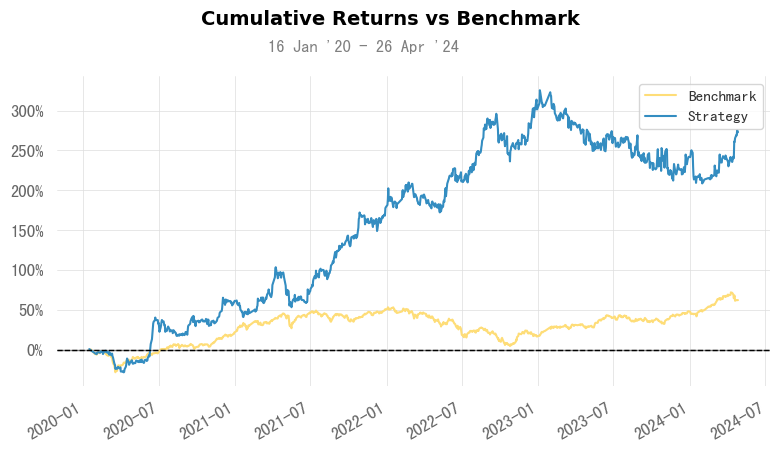

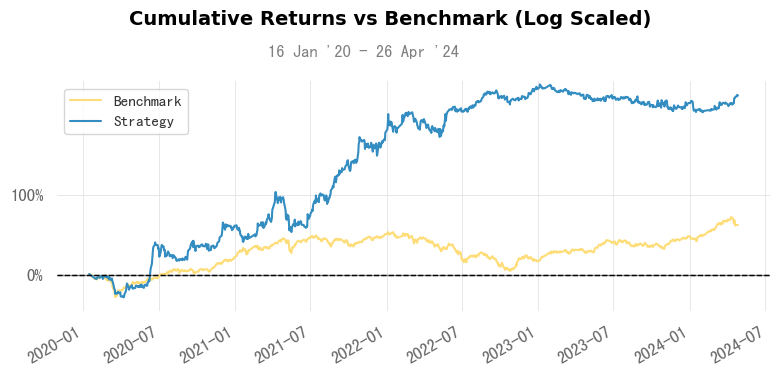

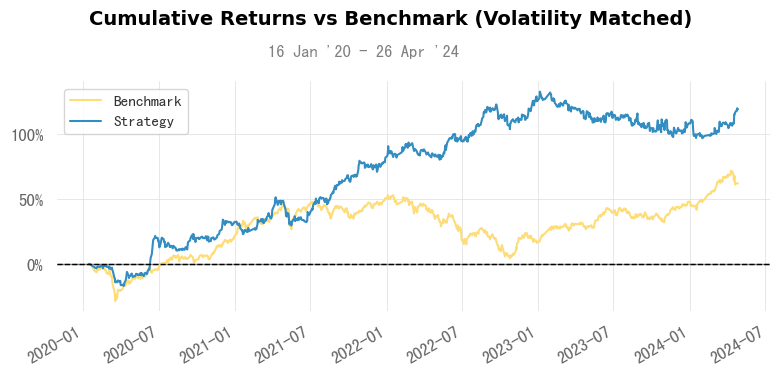

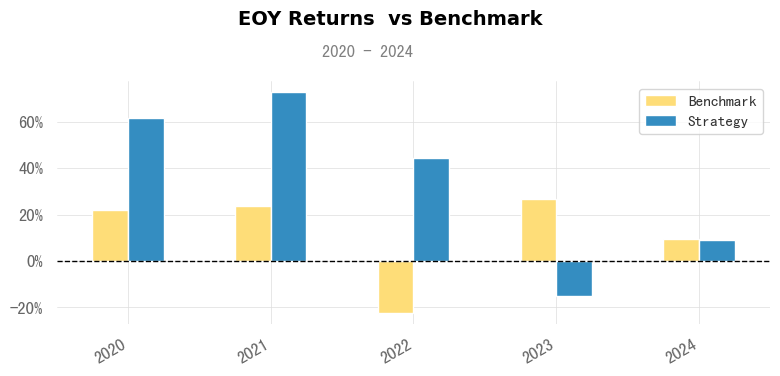

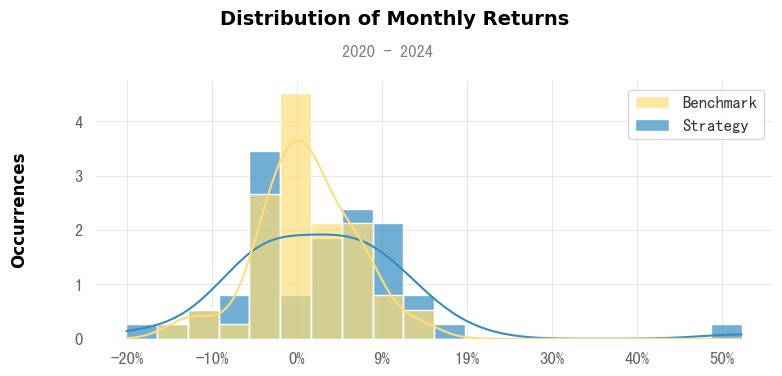

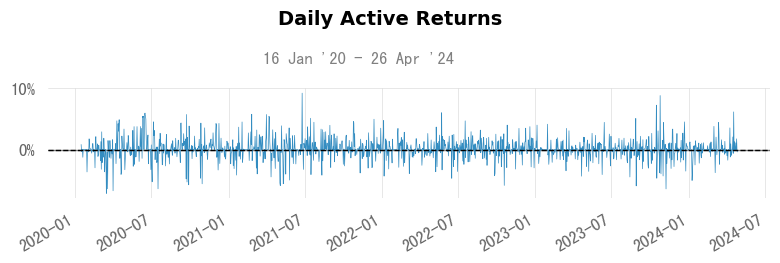

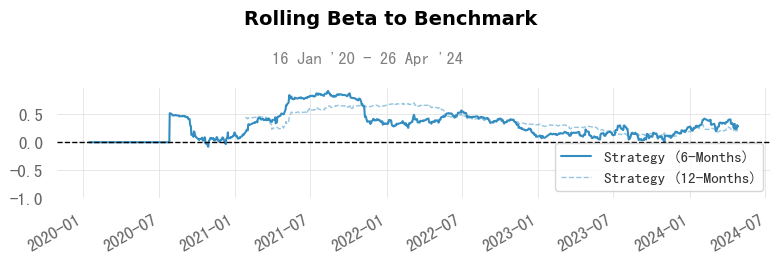

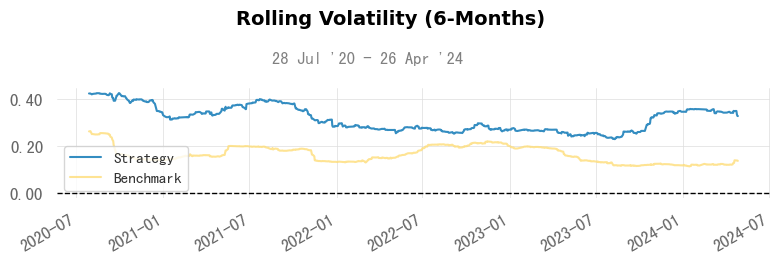

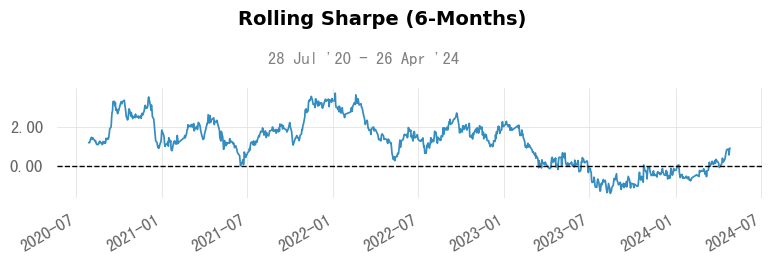

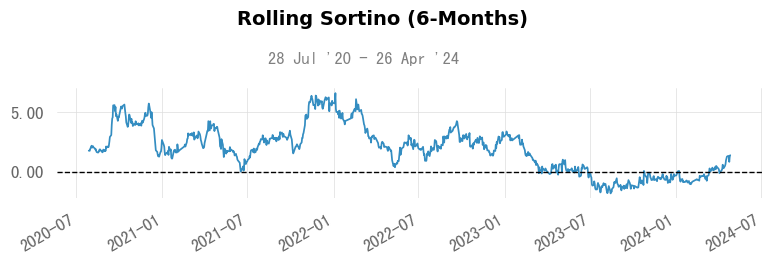

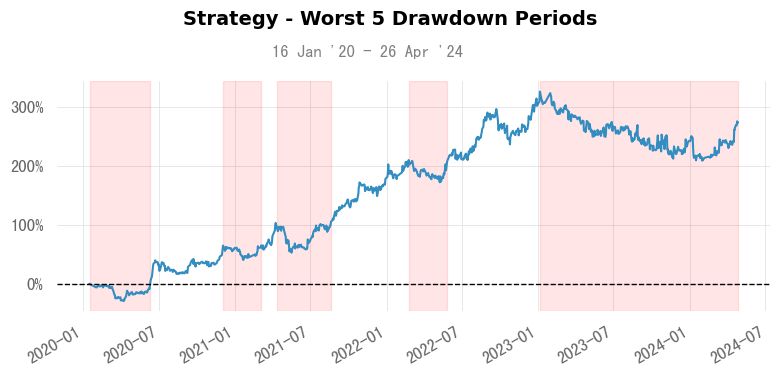

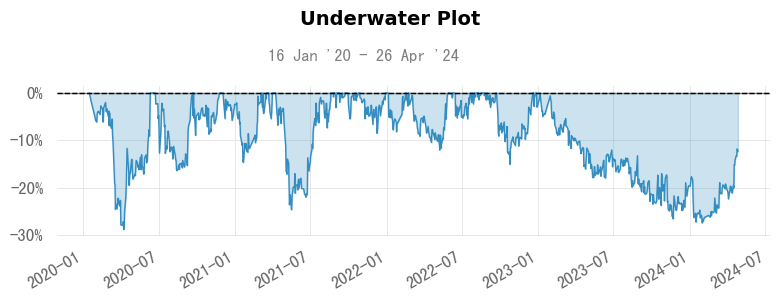

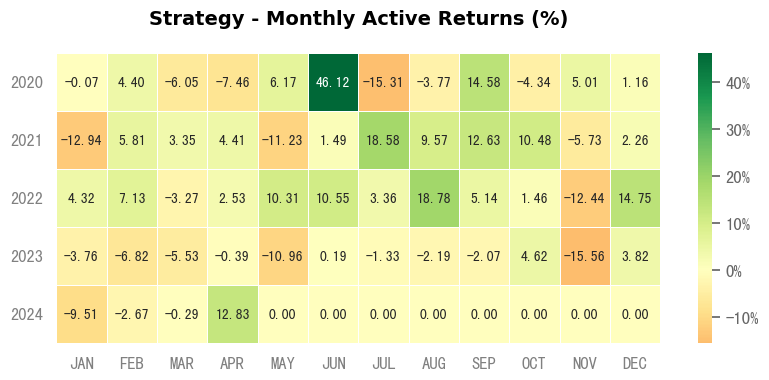

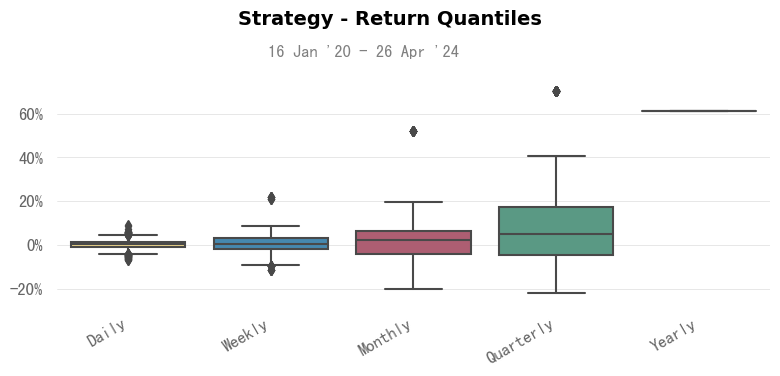

In [ ]:
qs.reports.full(df['2012':], benchmark = market_return['2020':],display = True)